In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from datetime import datetime

In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [29]:
mapping = [
           'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball',
           'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap',
           'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire',
           'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer',
           'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dragon', 'dresser', 'drill',
           'harp', 'hat', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hexagon', 'hockey_puck', 'hockey_stick', 'horse',
           'hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house_plant', 'house', 'hurricane', 'ice_cream', 'jacket',
           'paper_clip', 'parachute', 'parrot', 'passport', 'peanut', 'pear', 'peas', 'pencil', 'penguin', 'piano',
           'popsicle', 'postcard', 'potato', 'power_outlet', 'purse', 'rabbit', 'raccoon', 'radio', 'rain', 'rainbow',
           'trombone', 'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 'washing_machine', 'watermelon',
]

In [30]:
NUM_OBJECTS = 100

In [88]:
class Generator():
    def __init__(self,filenames,labels,batch_size,device):
        self.image_filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.device = device
        
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        images = []
        for fname in batch_x:
            with open(fname,"rb") as f:
                images.append(np.divide(np.load(f).astype("float32"),255.0))#normalize pixel values
        return torch.tensor(np.array(images),device=self.device).permute(0,3,1,2), torch.tensor(np.array(batch_y),device=self.device)
    
    def dataset_iterator(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

In [96]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='float32')[y]

def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [97]:
from sklearn.model_selection import train_test_split

filenames = []
labels = []
for lab in range(NUM_OBJECTS):
    labels += [lab for _ in range(10_000)]
    for i in range(10_000):
        filenames.append(f"dataset/images/{lab}/{i}.npy")

labels = to_categorical(labels,NUM_OBJECTS)
print(labels.dtype)


train_X,test_X,train_y,test_y = train_test_split(filenames,labels,test_size=0.1)

train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.22)

train_gen = Generator(train_X,train_y,32,device)
val_gen = Generator(val_X,val_y,16,device)

float32


In [98]:
val_gen.__getitem__(0)[1].shape

torch.Size([16, 100])

In [100]:
with torch.device(device):
    model = nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.LazyConv2d(64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.LazyLinear(512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.LazyLinear(256),
        nn.ReLU(),
        nn.LazyLinear(128),
        nn.ReLU(),
        nn.LazyLinear(NUM_OBJECTS),
        nn.LogSoftmax(1)
    )

In [118]:
def train_model(
        model:nn.Module,
        train_gen:Generator,
        val_gen:Generator,
        num_epochs:int = 50,
        num_early_stop:int = 10,
        num_lr_decrease:int = 3,
        lr_decrease_multiplier:float = 0.75,
        restore_best_weights:bool=True):
    
    loss_function = torch.nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters())

    best_accuracy = 0
    best_weights = None
    best_epoch = -1

    loss_values = []
    acc_values = []

    val_loss_values = []
    val_acc_values = []

    val_accs = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        model.train()  
        i = 0
        start_time = datetime.now()
        batches_total = len(train_gen)
        for X,y in train_gen.dataset_iterator():
            i+=1
            sec_training = (datetime.now()-start_time).total_seconds()
            print(f"\t{['-','\\','|','/'][i%4]}Batch {i}/{len(train_gen)} | Epoch time: {round(sec_training,2)} | Est. time left:{round(sec_training/i * (batches_total-i),2)}",end="\r")
            opt.zero_grad()
            logits = model(X)
            loss = loss_function(logits, y)
            loss.backward()
            opt.step()
        model.eval()
        print()

In [119]:
train_model(model,train_gen,val_gen,num_epochs=2)

Epoch 0
	Batch 21938/21938 | Epoch time: 630.42| Est. time left:0.0341
Epoch 1


KeyboardInterrupt: 

(64, 64, 1)


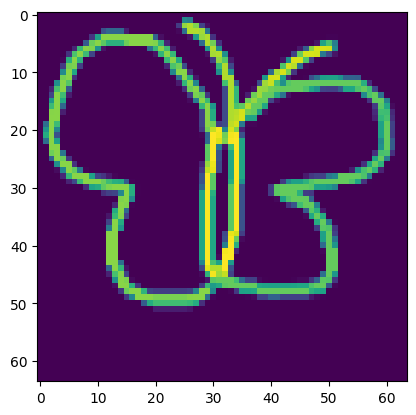

TRUE: butterfly,PREDICT: butterfly, 100.0%
(64, 64, 1)


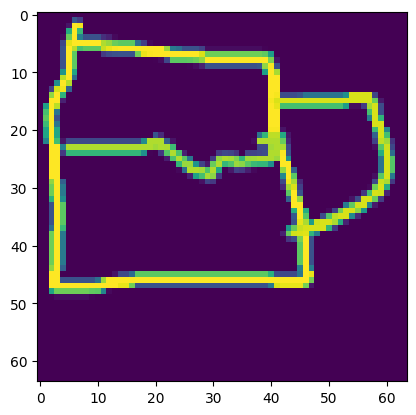

TRUE: coffee_cup,PREDICT: truck, 47.38%
(64, 64, 1)


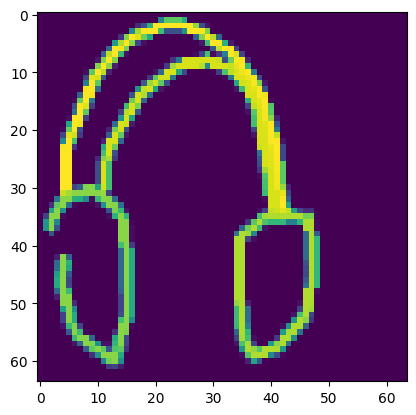

TRUE: headphones,PREDICT: headphones, 90.2%
(64, 64, 1)


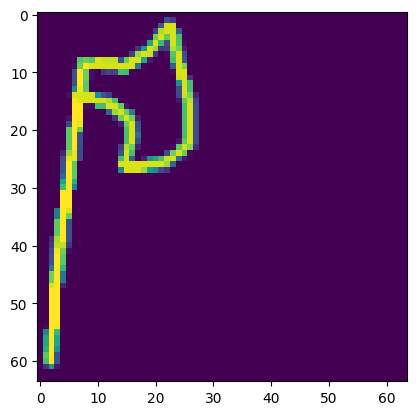

TRUE: axe,PREDICT: axe, 96.79%
(64, 64, 1)


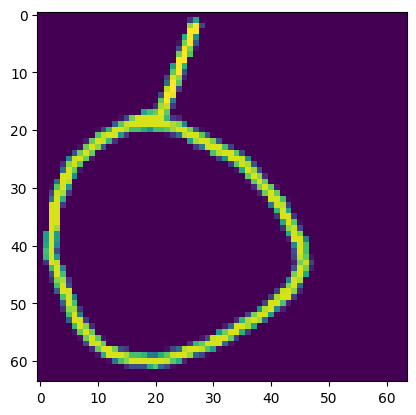

TRUE: pear,PREDICT: apple, 75.41%
(64, 64, 1)


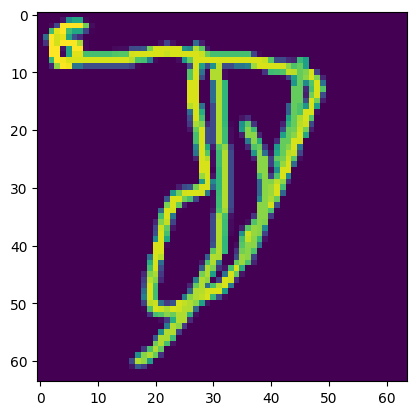

TRUE: harp,PREDICT: harp, 52.55%
(64, 64, 1)


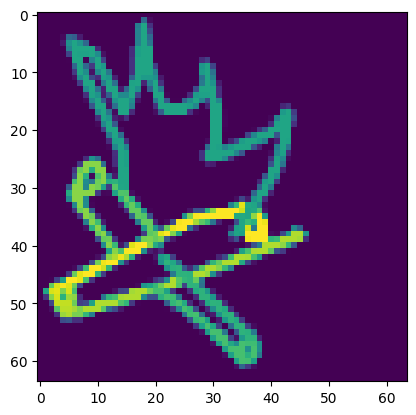

TRUE: campfire,PREDICT: campfire, 91.34%
(64, 64, 1)


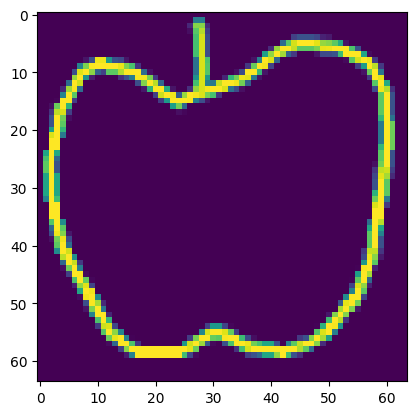

TRUE: apple,PREDICT: apple, 98.48%
(64, 64, 1)


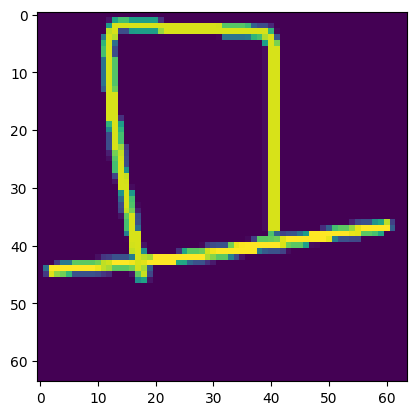

TRUE: hat,PREDICT: hat, 98.94%
(64, 64, 1)


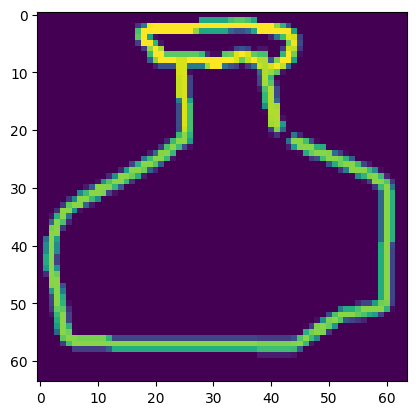

TRUE: bottlecap,PREDICT: bottlecap, 58.05%


In [129]:
from matplotlib import pyplot as plt

for i in range(10):
    fname = test_X[i]
    img = None
    with open(fname,"rb") as f:
        img = np.divide(np.load(f),255.0)
    print(img.shape)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
    label = np.argmax(test_y[i])
    X,y = Generator([fname],[test_y[i]],1,device).__getitem__(0)
    pred = model(X)[0].detach().cpu().numpy()
    
    pred_label = np.argmax(pred)
    perc = np.exp(pred)[pred_label]
    print(f'TRUE: {mapping[label]},PREDICT: {mapping[pred_label]}, {round(perc*100,2)}%')
    
